# GPU check

In [1]:
import torch
# Get GPU name, check if it's K80
GPU_name = torch.cuda.get_device_name()
print("Your GPU is {}!".format(GPU_name))

Your GPU is Tesla K80!


# Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics, svm, linear_model
import xgboost as xgb
from torchsummary import summary

# Data download

In [3]:
!gdown --id '1tWjPzb0jBWfXqWMqAwx0ku36PAipSu6f' --output cachexia.csv

Downloading...
From: https://drive.google.com/uc?id=1tWjPzb0jBWfXqWMqAwx0ku36PAipSu6f
To: /content/cachexia.csv
100% 8.31k/8.31k [00:00<00:00, 12.7MB/s]


In [4]:
df = pd.read_csv('/content/cachexia.csv')
df

,CaseNo,S100A8,S100A9,CA19-9,IL-6,TNF_a,Age,Sex,Stage,Tumor,Node,Metastasis,Size,Body_weight,Body_height,PCDM,cachexia
0,PD1075,3.379167,52.13973,138.20,7.733333,9.782609,38,0,4.0,4,0,0,3.4,54.299999,160.7,0,0
1,PD1322,5.562069,65.71664,200.40,0.000000,4.166667,64,0,4.0,2,1,1,2.9,59.000000,155.0,1,0
2,PD1201,3.015385,59.79299,3416.30,0.000000,0.000000,55,0,4.0,3,2,1,4.5,80.900002,158.4,0,0
3,PD1079,1.669231,56.59751,490.30,0.000000,48.548387,57,0,3.0,4,1,0,5.2,67.199997,169.9,1,0
4,PD1343,14.920833,70.29023,12000.00,0.000000,2.380952,58,0,4.0,3,0,1,7.5,47.000000,158.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,PD1335,9.670833,54.04842,23.63,159.677419,31.206897,64,1,4.0,4,1,1,8.8,67.000000,157.0,0,1
93,PD1145,6.295833,23.05316,7.90,67.164179,22.717391,62,1,4.0,4,1,1,4.2,58.000000,168.0,0,1
94,PD1062,4.879167,53.52779,11403.00,282.686567,27.717391,83,1,4.0,2,0,1,4.0,68.500000,166.0,1,1
95,PD1138,13.087500,72.64603,24000.00,763.460000,47.934783,83,1,4.0,2,0,1,2.8,64.699997,154.0,1,1


Descriptive statistics

In [5]:
df.loc[0:40,"cachexia"] = "PC"
df.loc[40:97,"cachexia"] = "PC-cachexia"
df

,CaseNo,S100A8,S100A9,CA19-9,IL-6,TNF_a,Age,Sex,Stage,Tumor,Node,Metastasis,Size,Body_weight,Body_height,PCDM,cachexia
0,PD1075,3.379167,52.13973,138.20,7.733333,9.782609,38,0,4.0,4,0,0,3.4,54.299999,160.7,0,PC
1,PD1322,5.562069,65.71664,200.40,0.000000,4.166667,64,0,4.0,2,1,1,2.9,59.000000,155.0,1,PC
2,PD1201,3.015385,59.79299,3416.30,0.000000,0.000000,55,0,4.0,3,2,1,4.5,80.900002,158.4,0,PC
3,PD1079,1.669231,56.59751,490.30,0.000000,48.548387,57,0,3.0,4,1,0,5.2,67.199997,169.9,1,PC
4,PD1343,14.920833,70.29023,12000.00,0.000000,2.380952,58,0,4.0,3,0,1,7.5,47.000000,158.0,1,PC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,PD1335,9.670833,54.04842,23.63,159.677419,31.206897,64,1,4.0,4,1,1,8.8,67.000000,157.0,0,PC-cachexia
93,PD1145,6.295833,23.05316,7.90,67.164179,22.717391,62,1,4.0,4,1,1,4.2,58.000000,168.0,0,PC-cachexia
94,PD1062,4.879167,53.52779,11403.00,282.686567,27.717391,83,1,4.0,2,0,1,4.0,68.500000,166.0,1,PC-cachexia
95,PD1138,13.087500,72.64603,24000.00,763.460000,47.934783,83,1,4.0,2,0,1,2.8,64.699997,154.0,1,PC-cachexia


In [6]:
# outlier
print("outlier")
print("IL-6: " + str(df.iloc[18, 4]))
print("CA19-9: " + str(df.iloc[68, 3]))

outlier
IL-6: 6281.6
CA19-9: 352300.0


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

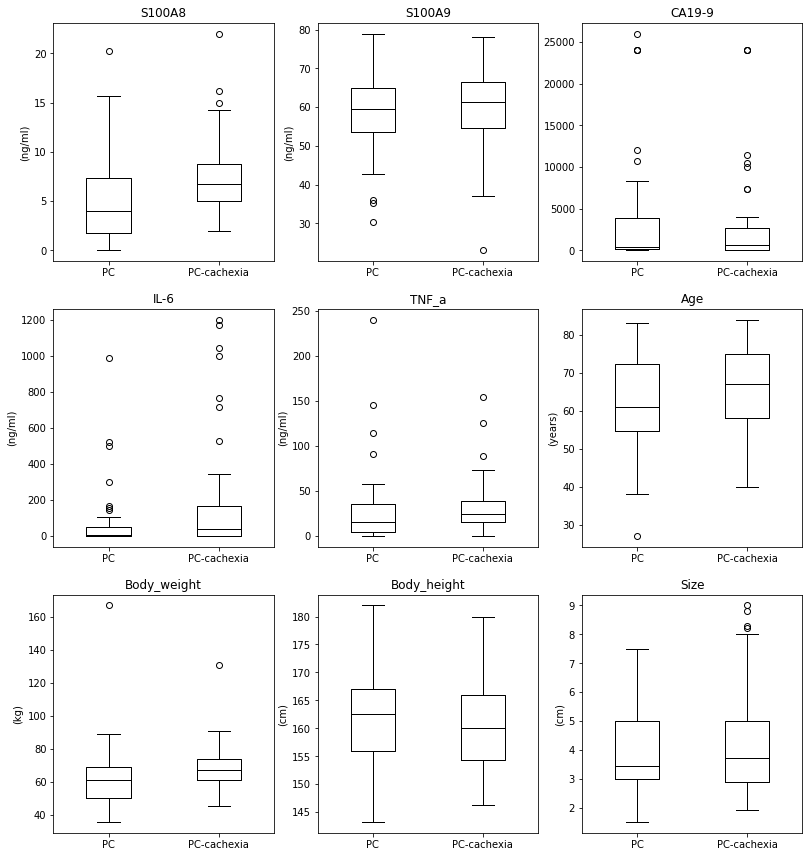

In [7]:
df.iloc[18, 4] = 0
df.iloc[68, 3] = 0

def BoxPlot(col_name, y_label, pos):
  col_name = str(col_name)
  y_label = str(y_label)
  df_box = df.boxplot(column=col_name,grid=False, by="cachexia", figsize=(2.5,5), widths=0.4, color="black", ax=pos)
  df_box.get_figure().suptitle('')
  df_box.set(xlabel="", ylabel=y_label)
  return df_box

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 15))
BoxPlot("S100A8", "(ng/ml)", axes[0,0])
BoxPlot("S100A9", "(ng/ml)", axes[0,1])
BoxPlot("CA19-9", "", axes[0,2])
BoxPlot("IL-6", "(ng/ml)", axes[1,0])
BoxPlot("TNF_a", "(ng/ml)", axes[1,1])
BoxPlot("Age", "(years)", axes[1,2])
BoxPlot("Body_weight", "(kg)", axes[2,0])
BoxPlot("Body_height", "(cm)", axes[2,1])
BoxPlot("Size", "(cm)", axes[2,2])
plt.savefig("boxplot.png", dpi = 300)

In [8]:
df.loc[0:40,"cachexia"] = 0
df.loc[40:97,"cachexia"] = 1
df.iloc[18, 4] = 6281.6
df.iloc[68, 3] = 352300.0

df = df.iloc[:, 1:17]
print(df)

       S100A8    S100A9    CA19-9  ...  Body_height  PCDM  cachexia
0    3.379167  52.13973    138.20  ...        160.7     0         0
1    5.562069  65.71664    200.40  ...        155.0     1         0
2    3.015385  59.79299   3416.30  ...        158.4     0         0
3    1.669231  56.59751    490.30  ...        169.9     1         0
4   14.920833  70.29023  12000.00  ...        158.0     1         0
..        ...       ...       ...  ...          ...   ...       ...
92   9.670833  54.04842     23.63  ...        157.0     0         1
93   6.295833  23.05316      7.90  ...        168.0     0         1
94   4.879167  53.52779  11403.00  ...        166.0     1         1
95  13.087500  72.64603  24000.00  ...        154.0     1         1
96   2.754167  54.74494    380.20  ...        160.0     0         1

[97 rows x 16 columns]


# Neural network

In [9]:
df_array = df.to_numpy(dtype = "float32")
df_tensor = torch.from_numpy(df_array)
df_tensor.shape

torch.Size([97, 16])

## Data prepare

In [10]:
class CachaxiaDataset(Dataset):
  def __init__(self, x):
    self.data = df_tensor[x,0:15]
    self.label = torch.FloatTensor(df_array[:, 15].astype(float))
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):

    return self.data[index], self.label[index]

  def shape(self):
    print(self.data.shape)

In [11]:
seed = 22
validation_ratio = 0.49

validation_number = int(len(df_tensor) * validation_ratio)

total_list = range(len(df_tensor))
total_list = np.array(total_list)

np.random.seed(seed)
val_list = np.random.choice(total_list, size = int(validation_number), replace = False)
train_list = np.setdiff1d(total_list, val_list)

print("training sample size = " + str(len(train_list)))
print("training sample list = " + str(train_list))
print()
print("validation sample size = " + str(len(val_list)))
print("validatin sample list = " + str(val_list))

training sample size = 50
training sample list = [ 1  3  4  5  7  8  9 11 13 14 17 18 19 20 21 23 27 29 34 36 38 39 40 41
 44 45 47 48 52 53 57 58 59 60 62 64 66 67 70 72 75 77 79 81 84 86 88 92
 94 95]

validation sample size = 47
validatin sample list = [74 12 30 26 96 22 51 61 42 78 65 68  2 83 37 33 87  0 35 54 71 31 69 85
 82 63 73 10 76 80 93 46 50 90 24 55 16 25 89 28 15  6 49 43 91 32 56]


In [12]:
train_set = CachaxiaDataset(train_list)
val_set = CachaxiaDataset(val_list)
train_loader = DataLoader(train_set, batch_size=25, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

train_set.shape()

torch.Size([50, 15])


## Create model

In [13]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(15, 24),
        nn.Dropout(0.05),
        nn.BatchNorm1d(24),
        nn.Sigmoid(),
        nn.Linear(24, 6),
        nn.BatchNorm1d(6),
        nn.Sigmoid(),      
        nn.Linear(6, 1),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.net(x).squeeze(1)


Set seed

In [14]:
def random_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

random_seed(seed)

## Training

In [15]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(f'DEVICE: {device}')

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = NeuralNetwork().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

DEVICE: cuda


In [16]:
epoch = 2000

best_loss = 9999999

for i in range(epoch):
  train_loss = 0.0
  val_loss = 0.0

  model.train()
  for x, y in train_loader:
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  model.eval()
  for x, y in val_loader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      output = model(x)
      loss = criterion(output, y)
      val_loss += loss.item()

    if val_loss < best_loss:
      best_loss = val_loss
      torch.save(model.state_dict(), model_path)


  print("epoch = " + str(i+1) + " : training loss = " + str(train_loss) + " and validation loss = " + str(val_loss))




epoch = 1 : training loss = 1.4092079401016235 and validation loss = 4.076877534389496
epoch = 2 : training loss = 1.3906440138816833 and validation loss = 4.079647362232208
epoch = 3 : training loss = 1.388181746006012 and validation loss = 4.081604599952698
epoch = 4 : training loss = 1.3714682459831238 and validation loss = 4.082591950893402
epoch = 5 : training loss = 1.3940805792808533 and validation loss = 4.083798706531525
epoch = 6 : training loss = 1.3851600289344788 and validation loss = 4.082292020320892
epoch = 7 : training loss = 1.3814427256584167 and validation loss = 4.080261170864105
epoch = 8 : training loss = 1.3664660453796387 and validation loss = 4.077638268470764
epoch = 9 : training loss = 1.3584274053573608 and validation loss = 4.0740931034088135
epoch = 10 : training loss = 1.3601820468902588 and validation loss = 4.071785628795624
epoch = 11 : training loss = 1.3587778210639954 and validation loss = 4.068301618099213
epoch = 12 : training loss = 1.3583207130

In [17]:
for p in model.parameters():
  print(p)

Parameter containing:
tensor([[-9.8825e-02,  2.0652e-01, -1.0340e-01, -2.4270e-01,  4.6675e-02,
         -8.3695e-03,  1.3303e+00,  1.9366e-01,  5.1004e-01,  6.1680e-01,
          4.0787e-01,  6.2893e-01,  5.3619e-02,  8.6267e-02,  1.2192e-01],
        [-1.7693e-01, -2.5611e-01,  2.5161e-02,  2.0490e-01,  3.9132e-02,
         -1.2300e-01, -2.4121e+00,  5.2614e-01,  9.9008e-02, -4.3730e-01,
         -7.6791e-02, -2.9834e-01,  1.6030e-02, -3.6286e-01, -4.9627e-01],
        [ 4.6793e-01, -7.2820e-02,  1.3465e-03, -7.6471e-03,  1.8852e-02,
         -5.0898e-02,  2.6156e+00, -7.5486e-01, -4.3558e-01,  3.5791e-01,
          2.5148e-01,  1.5033e-01, -2.6967e-01,  1.4436e-01,  3.2997e-01],
        [-2.6001e-01,  7.8788e-02,  2.4565e-03,  6.5753e-04,  3.1302e-01,
          1.3204e-01, -2.8896e+00,  7.4853e-01,  4.6325e-01, -3.5963e-01,
         -2.8709e-01, -3.5708e-01, -5.1478e-02, -2.1712e-01, -3.6771e-01],
        [ 2.5609e-01, -6.5837e-02,  9.1581e-05, -5.7100e-03,  3.9730e-01,
          4.

In [18]:
print(model)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=24, bias=True)
    (1): Dropout(p=0.05, inplace=False)
    (2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Sigmoid()
    (4): Linear(in_features=24, out_features=6, bias=True)
    (5): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Sigmoid()
    (7): Linear(in_features=6, out_features=1, bias=True)
    (8): Sigmoid()
  )
)


In [19]:
summary(model, (15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]             384
           Dropout-2                   [-1, 24]               0
       BatchNorm1d-3                   [-1, 24]              48
           Sigmoid-4                   [-1, 24]               0
            Linear-5                    [-1, 6]             150
       BatchNorm1d-6                    [-1, 6]              12
           Sigmoid-7                    [-1, 6]               0
            Linear-8                    [-1, 1]               7
           Sigmoid-9                    [-1, 1]               0
Total params: 601
Trainable params: 601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------

## Prediction

In [20]:
train_loader2 = DataLoader(train_set, batch_size=20, shuffle=False)

train_predict = []
validation_predict = []

model.eval()
with torch.no_grad():
  for x, y in train_loader2:
    x, y = x.to(device), y.to(device)
    train_pred = model(x)
    for i in train_pred.cpu().numpy():
      train_predict.append(i)

model.eval()
with torch.no_grad():
  for x, y in val_loader:
    x, y = x.to(device), y.to(device)
    val_pred = model(x)
    for i in val_pred.cpu().numpy():
      validation_predict.append(i)

print("training prediction")
print(train_predict)
print()
print("validation prediction")
print(validation_predict)

training prediction
[0.047185495, 0.013460517, 0.011763245, 0.0133281825, 0.029603802, 0.13480723, 0.009040603, 0.016760752, 0.014631569, 0.017583093, 0.03612606, 0.009566142, 0.010824971, 0.19154625, 0.010758801, 0.02212741, 0.036052544, 0.014181129, 0.010546394, 0.014405803, 0.08946202, 0.15764986, 0.009906943, 0.12116891, 0.011560252, 0.012224152, 0.021870878, 0.01605822, 0.014173392, 0.045799524, 0.20433773, 0.062178485, 0.025712512, 0.025301874, 0.016188314, 0.6523503, 0.07660198, 0.6403065, 0.03839012, 0.09334872, 0.65322924, 0.54582155, 0.4929963, 0.49914068, 0.6282877, 0.64285433, 0.46603185, 0.47399804, 0.08076019, 0.21641684]

validation prediction
[0.12503937, 0.015879625, 0.5806456, 0.21890627, 0.33433542, 0.63940024, 0.17032295, 0.008994337, 0.35839352, 0.10030016, 0.12513168, 0.019238146, 0.016206248, 0.24162382, 0.1931317, 0.061030842, 0.4756937, 0.008873656, 0.07689225, 0.063531965, 0.058644325, 0.033956844, 0.07513508, 0.569291, 0.48022717, 0.59660614, 0.029252818, 0.0

# SVM

In [21]:
# data prepare

train_X = df_array[train_list, 0:15]
train_Y = df_array[train_list, 15]
valid_X = df_array[val_list, 0:15]
valid_Y = df_array[val_list, 15]

# SVM

model_svm = svm.SVC(kernel = 'linear', C = 0.003, probability = True)
model_svm.fit(train_X, train_Y)

train_svm = model_svm.decision_function(train_X)
val_svm = model_svm.decision_function(valid_X)

print("training prediction")
print(train_svm)
print("validation prediction")
print(val_svm)

training prediction
[ 6.69590067e-01 -8.47919876e-01  5.99370723e-01  8.05551374e-01
  9.19271921e-01  2.69708581e-01 -8.22229464e-01 -9.38535677e-01
 -2.01537934e-02 -7.76983908e-01 -8.97167320e-01 -9.97800958e-01
  5.35720018e+00 -6.66010106e-01 -1.00800066e+00 -5.55339270e-01
 -3.42720903e-01 -4.43091120e-02 -8.55662536e-01 -1.00011732e+00
 -1.00248965e+00 -7.06562025e-02  3.34079448e-01  1.00000623e+00
  3.85664336e-03  5.63810310e-01 -7.63865708e-02 -9.78066214e-02
  1.02327353e+00  4.05292059e-01  1.52519983e+00  6.01699510e-01
  1.15169134e+00  4.37365776e-01  9.99799262e-01  1.22316047e+00
  4.43823345e-01  1.44073479e+00  8.21184125e-01 -1.76885121e-02
  1.36410648e+00 -3.01234693e-01  2.55494441e-02  3.42631165e-01
  9.99521885e-01  9.73849995e-01  1.23240659e+00  8.92548033e-01
 -8.67358987e-02  1.01211797e+00]
validation prediction
[ 0.0972963  -0.86519881  2.20463084 -0.81192808  0.29334964  0.84378257
  0.54397412 -0.52870407  1.21040505  0.84379246 -0.20624721 -6.9903325

# XGBoost

In [22]:
num_round = 31
param = {'max_depth': 3,
         'gamma': 0.15,
         'eta': 0.24,
         'objective': 'binary:logistic',
         "booster" : "gbtree",
         "eval_metric": "auc",
         "subsample" : "0.5",
         "colsample_bytree": "0.6",
         'tree_method': 'exact'}
dtrain = xgb.DMatrix(train_X, train_Y)
dvalid = xgb.DMatrix(valid_X, valid_Y)
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

bst = xgb.train(param, dtrain, num_round, evallist)

train_xgb = bst.predict(dtrain)
val_xgb = bst.predict(dvalid)

[0]	eval-auc:0.650383	train-auc:0.594156
[1]	eval-auc:0.631226	train-auc:0.695617
[2]	eval-auc:0.479885	train-auc:0.644481
[3]	eval-auc:0.561303	train-auc:0.767857
[4]	eval-auc:0.590996	train-auc:0.793831
[5]	eval-auc:0.671456	train-auc:0.848214
[6]	eval-auc:0.643678	train-auc:0.867695
[7]	eval-auc:0.676245	train-auc:0.876623
[8]	eval-auc:0.729885	train-auc:0.878247
[9]	eval-auc:0.670498	train-auc:0.924513
[10]	eval-auc:0.664751	train-auc:0.931006
[11]	eval-auc:0.720307	train-auc:0.93263
[12]	eval-auc:0.706897	train-auc:0.948864
[13]	eval-auc:0.735632	train-auc:0.959416
[14]	eval-auc:0.741379	train-auc:0.965909
[15]	eval-auc:0.749042	train-auc:0.959416
[16]	eval-auc:0.795019	train-auc:0.954545
[17]	eval-auc:0.806513	train-auc:0.954545
[18]	eval-auc:0.796935	train-auc:0.952922
[19]	eval-auc:0.814176	train-auc:0.954545
[20]	eval-auc:0.791188	train-auc:0.959416
[21]	eval-auc:0.800766	train-auc:0.957792
[22]	eval-auc:0.821839	train-auc:0.975649
[23]	eval-auc:0.842912	train-auc:0.970779
[24

In [23]:
print("training prediction")
print(train_xgb)
print("validation prediction")
print(val_xgb)

training prediction
[0.5536442  0.10052429 0.29541427 0.6223882  0.28690702 0.3342408
 0.14467953 0.2400024  0.17159417 0.28994614 0.21839996 0.5063822
 0.3519574  0.36622587 0.1703664  0.16374838 0.6815383  0.20368771
 0.12755363 0.3667822  0.371891   0.09061924 0.72410446 0.7224286
 0.7414017  0.82047135 0.7607069  0.68505144 0.9392233  0.8094521
 0.939743   0.8970619  0.87988746 0.968159   0.8152602  0.66378605
 0.6302539  0.82831615 0.7408659  0.57286906 0.5598496  0.53395706
 0.8799789  0.71004206 0.70895964 0.9298999  0.9044836  0.8751904
 0.76825255 0.89537746]
validation prediction
[0.7271986  0.2849201  0.4529766  0.26981696 0.6035593  0.5039542
 0.74366844 0.35965002 0.78297156 0.5608395  0.38652223 0.634481
 0.3528989  0.48418078 0.3798933  0.28418636 0.65735465 0.1126387
 0.49528474 0.6621396  0.31339702 0.44940653 0.5437891  0.6512978
 0.71894604 0.5401305  0.30922484 0.4847443  0.79700416 0.6126167
 0.6500498  0.86455876 0.8524916  0.8531764  0.32518747 0.5130951
 0.37870

/usr/local/lib/python3.7/dist-packages/xgboost/plotting.py:275: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 1)
/usr/local/lib/python3.7/dist-packages/xgboost/plotting.py:275: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 1)
/usr/local/lib/python3.7/dist-packages/xgboost/plotting.py:275: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

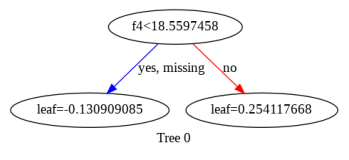

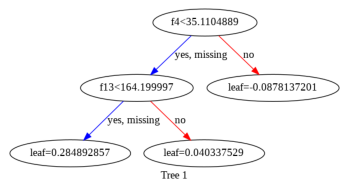

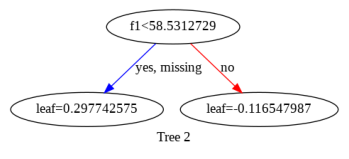

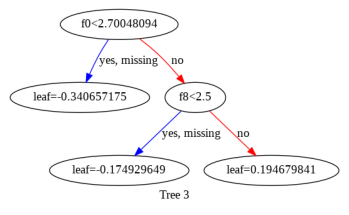

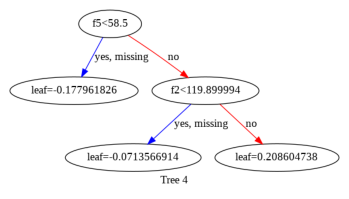

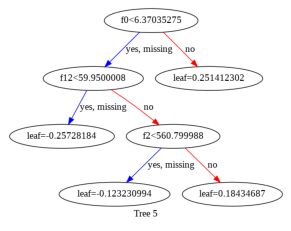

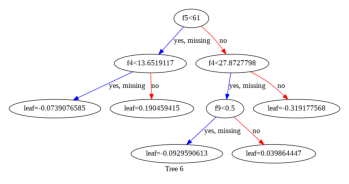

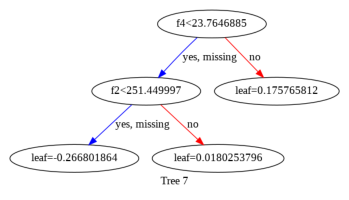

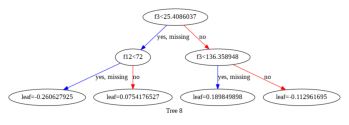

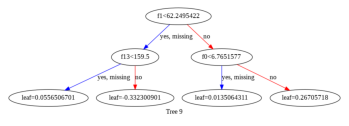

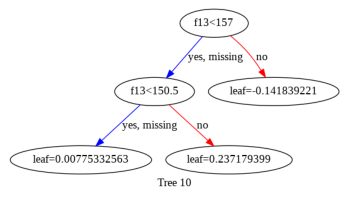

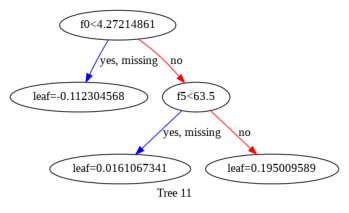

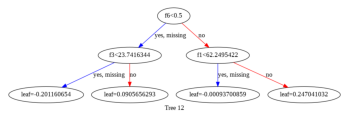

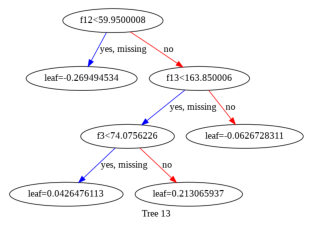

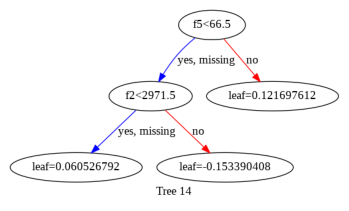

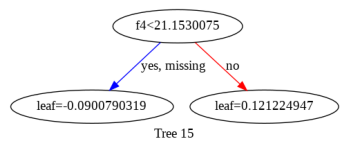

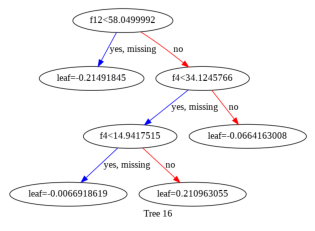

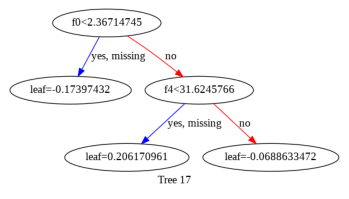

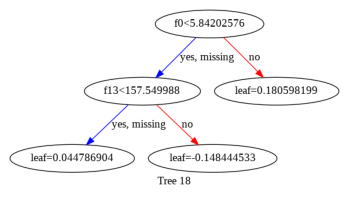

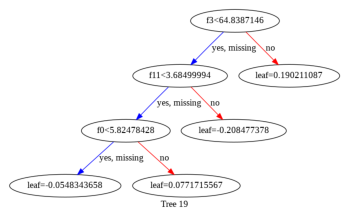

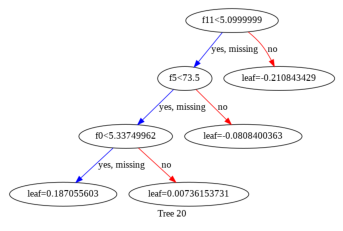

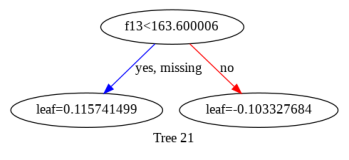

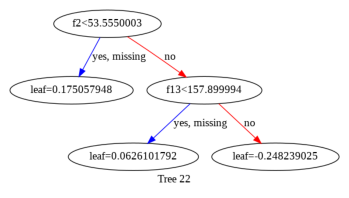

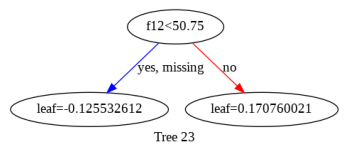

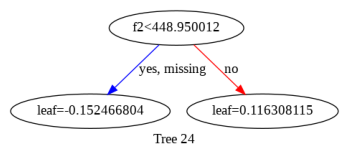

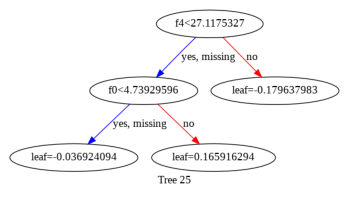

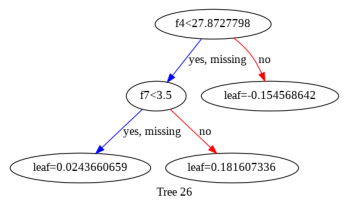

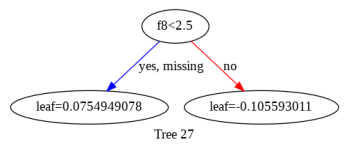

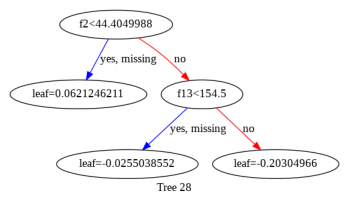

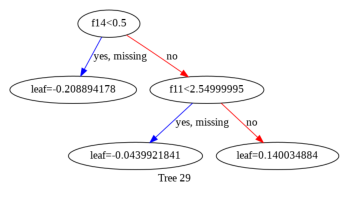

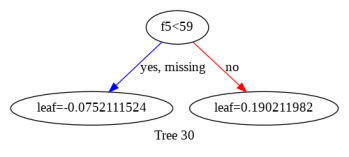

In [24]:
for tree_i in range(num_round):
  xgb.plot_tree(bst, num_trees=tree_i, label="Tree "+str(tree_i))

# ROC curve

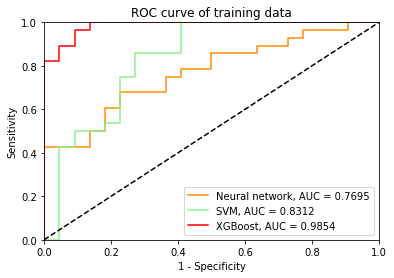

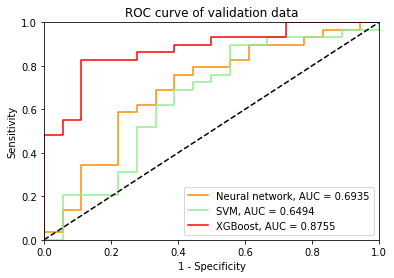

In [25]:
train_nn = np.array(train_predict)
train_s100a8 = df_array[train_list, 0]
train_s100a9 = df_array[train_list, 1]
train_il6 = df_array[train_list, 3]
train_tnfa = df_array[train_list, 4]
train_label = df_array[train_list, 15]

val_nn = validation_predict
val_s100a8 = df_array[val_list, 0]
val_s100a9 = df_array[val_list, 1]
val_il6 = df_array[val_list, 3]
val_tnfa = df_array[val_list, 4]
val_label = df_array[val_list, 15]

def ROC_curve(model_name, predict_t, predict_v, curve_color, data_state):
  name_dict = {"s100a8": "S100A8", "s100a9": "S100A9", "il6": "IL-6", "tnfa": "TNF-"+chr(945), "nn": "Neural network", "svm": "SVM", "xgb": "XGBoost", "glm": "S100A8+S100A9"}
  model_name = str(model_name)
  curve_color = str(curve_color)

  if data_state == "t":
    fpr_t, tpr_t, thresholds_t = metrics.roc_curve(train_label, predict_t)
    auc_t = metrics.roc_auc_score(train_label, predict_t)
    plot_curve_t = plt.plot(fpr_t, tpr_t, color = curve_color, label = name_dict[model_name] + ", AUC = " + str(round(auc_t, 4)))
    return plot_curve_t
  elif data_state == "v":
    fpr_v, tpr_v, thresholds_v = metrics.roc_curve(val_label, predict_v)
    auc_v = metrics.roc_auc_score(val_label, predict_v)
    plot_curve_v = plt.plot(fpr_v, tpr_v, color = curve_color, label = name_dict[model_name] + ", AUC = " + str(round(auc_v, 4)))
    return plot_curve_v
  else:
    return None

# ROC curve of training data
plt.figure()
#ROC_curve("s100a8", train_s100a8, val_s100a8, "lightblue", "t")
#ROC_curve("s100a9", train_s100a9, val_s100a9, "darkgray", "t")
ROC_curve("nn", train_nn, val_nn, "darkorange", "t")
ROC_curve("svm", train_svm, val_svm, "lightgreen", "t")
ROC_curve("xgb", train_xgb, val_xgb, "red", "t")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve of training data')
plt.legend(loc="lower right")
plt.savefig("ROC curve of training data.png", dpi = 300)
plt.show()

# ROC curve of validation data
plt.figure()
#ROC_curve("s100a8", train_s100a8, val_s100a8, "lightblue", "v")
#ROC_curve("s100a9", train_s100a9, val_s100a9, "darkgray", "v")
ROC_curve("nn", train_nn, val_nn, "darkorange", "v")
ROC_curve("svm", train_svm, val_svm, "lightgreen", "v")
ROC_curve("xgb", train_xgb, val_xgb, "red", "v")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve of validation data')
plt.legend(loc="lower right")
plt.savefig("ROC curve of validation data.png", dpi = 300)
plt.show()